In [1]:
import requests
import json
import pandas as pd
import csv
import datetime
import dateutil.parser
import unicodedata
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
#This module provides regular expressions

In [2]:
# Reads dataset file
df = pd.read_csv('Data_Set_Student_Reviews.csv', header = None, encoding='utf-8')

# Changes header title
df.columns=['Text']

df

Text
0    1.                 Before uploading the video ...
1    2.                Before, she is kind to her s...
2    3.                Can be improved. Hope she co...
3    4.                For this subject, some topic...
4                5.                Give more examples.
..                                                 ...
848  846.       The professor was active in google ...
849   847.        Very nice and accommodating teacher!
850  848.       Words  can''t express how i am grat...
851  849.       in my opinion, the instructor''s wa...
852  850.        please speak tagalog when teaching...

[853 rows x 1 columns]

In [3]:
# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = text.lower()
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = re.sub('httpS+s*', ' ',text)  # remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('#S+', '', text)  # remove hashtags
    text = re.sub('@S+', '  ', text)  # remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7F]+',r' ', text) # replace non-ASCII characters
    text = re.sub('\s\s+', ' ', text)  # remove extra whitespace
    return text

# Cleaning the text in the Text column
df['Cleaned_Text'] = df['Text'].apply(clean)
df

Text  \
0    1.                 Before uploading the video ...   
1    2.                Before, she is kind to her s...   
2    3.                Can be improved. Hope she co...   
3    4.                For this subject, some topic...   
4                5.                Give more examples.   
..                                                 ...   
848  846.       The professor was active in google ...   
849   847.        Very nice and accommodating teacher!   
850  848.       Words  can''t express how i am grat...   
851  849.       in my opinion, the instructor''s wa...   
852  850.        please speak tagalog when teaching...   

                                          Cleaned_Text  
0     before uploading the video discussion i sugge...  
1     before she is kind to her students my classma...  
2     can be improved hope she considers personal n...  
3     for this subject some topics are not easy but...  
4                                  give more examples   
..                                                 ...  
848   the professor was active in google meets spec...  
849                very nice and a ommodating teacher   
850   words can t express how i am grateful with ou...  
851   in my opinion the instructor s way of encoura...  
852          please speak tagalog when teaching please  

[853 rows x 2 columns]

In [4]:
df.loc[0, 'Text']

'1.\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 Before uploading the video discussion, I suggest that she discuss it clearly and remove the errors because it can confuse our Course 1  class.'

In [5]:
df.loc[0, 'Cleaned_Text']

' before uploading the video discussion i suggest that she discuss it clearly and remove the errors because it can confuse our course class '

In [6]:
# Sorts Text column
df.sort_values('Text', inplace = True)

# Counts numbers of duplicates
duplicates = df.pivot_table(columns=['Text'], aggfunc='size')
duplicates

Text
-                   She didn''t release our grades from prelims to midterms."                                                                                                                                                                                                                                                                                                                                                                                                             1
-                   Titus 2:7-8"                                                                                                                                                                                                                                                                                                                                                                                                                                                          1
-                   she only reads the modu

In [7]:
# Drops all duplicate values 
df.drop_duplicates(subset ="Text",keep = False, inplace = True)
df

Text  \
170  -                   She didn''t release our gr...   
49                    -                   Titus 2:7-8"   
311  -                   she only reads the module ...   
0    1.                 Before uploading the video ...   
9    10.             I appreciate the faculty conce...   
..                                                 ...   
95   95.            Activities are timed which is o...   
96   96.           At first, I liked my professor b...   
97   97.            Doesn''t conduct classes, but p...   
98                        98.           Excellent prof   
99   99.           For the duration of this semeste...   

                                          Cleaned_Text  
170   she didn t release our grades from prelims to...  
49                                              titus   
311   she only reads the module when she is having ...  
0     before uploading the video discussion i sugge...  
9     i appreciate the faculty concerned in this su...  
..                                                 ...  
95    activities are timed which is okay but someti...  
96    at first i liked my professor because she is ...  
97         doesn t conduct classes but post activities  
98                                      excellent prof  
99    for the duration of this semester she never d...  

[853 rows x 2 columns]

In [8]:
#check for null values in dataset
df.isnull().values.any()

False

In [9]:
#set english stopwords
import nltk
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
stop_words_en=set(stopwords)
print(stop_words_en)

{'the', 'until', 'she', 'd', 'myself', 'my', 'he', "she's", 'themselves', 'both', 'any', 'will', "haven't", "couldn't", "hasn't", 'an', 'only', "you've", 'her', 'has', 'nor', 'where', 'same', "weren't", 'o', 'no', 'whom', 'was', 'down', 'out', 'against', 'your', 'don', 'hadn', "it's", "needn't", 'shouldn', 'these', 'too', "isn't", 'before', 'wouldn', 'me', 'and', 'on', 'wasn', 'didn', 'needn', 'all', 'just', 'of', 'y', "doesn't", 'won', 'itself', 'each', 'again', 'him', 'do', 'further', "wouldn't", 'haven', 'how', 'but', 'those', 'to', 'such', 'll', 'who', "you'll", 'this', 'now', 'most', "shan't", 'through', 'had', 'himself', "that'll", 'below', "shouldn't", 'ourselves', 'is', 'what', 'by', 'over', 'have', 'under', 'i', 'them', 'there', 'more', 'theirs', 'm', 'isn', "don't", 'does', 'mightn', 'for', 'hasn', 'been', 'very', 'doesn', 'not', 'am', 'some', "should've", 'couldn', 'that', 'should', 'herself', 'into', 'yourselves', 'being', 've', "you'd", 'here', 'were', "didn't", 'when', "h

In [10]:
#removing english and tagalog stopwords
from nltk.tokenize import word_tokenize
def removing_en_stopwords(text):
    tokens = word_tokenize(text)
    text = [word for word in tokens if not word
in stop_words_en]
    return text
df['removed_stopwords'] = df.Cleaned_Text.apply(lambda x: removing_en_stopwords(x))
df['removed_stopwords'][0]

['uploading',
 'video',
 'discussion',
 'suggest',
 'discuss',
 'clearly',
 'remove',
 'errors',
 'confuse',
 'course',
 'class']

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['Cleaned_Text'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['Cleaned_Text']], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[df['Cleaned_Text'][0]]])

[' ', 'b', 'e', 'f', 'o', 'r', 'e', ' ', 'u', 'p', 'l', 'o', 'a', 'd', 'i', 'n', 'g', ' ', 't', 'h', 'e', ' ', 'v', 'i', 'd', 'e', 'o', ' ', 'd', 'i', 's', 'c', 'u', 's', 's', 'i', 'o', 'n', ' ', 'i', ' ', 's', 'u', 'g', 'g', 'e', 's', 't', ' ', 't', 'h', 'a', 't', ' ', 's', 'h', 'e', ' ', 'd', 'i', 's', 'c', 'u', 's', 's', ' ', 'i', 't', ' ', 'c', 'l', 'e', 'a', 'r', 'l', 'y', ' ', 'a', 'n', 'd', ' ', 'r', 'e', 'm', 'o', 'v', 'e', ' ', 't', 'h', 'e', ' ', 'e', 'r', 'r', 'o', 'r', 's', ' ', 'b', 'e', 'c', 'a', 'u', 's', 'e', ' ', 'i', 't', ' ', 'c', 'a', 'n', ' ', 'c', 'o', 'n', 'f', 'u', 's', 'e', ' ', 'o', 'u', 'r', ' ', 'c', 'o', 'u', 'r', 's', 'e', ' ', 'c', 'l', 'a', 's', 's', ' ']


In [12]:

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Form Bigrams
data_words_bigrams = make_bigrams(df['removed_stopwords'])

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download ennlp = spacy.load("en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['grade', 'prelim', 'midterm']]


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1)]]


[[('grade', 1), ('midterm', 1), ('prelim', 1)]]

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [37]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.060*"well" + 0.058*"topic" + 0.049*"make" + 0.038*"student" + '
  '0.035*"motivate" + 0.030*"video" + 0.027*"understand" + 0.026*"sure" + '
  '0.023*"discussion" + 0.023*"help"'),
 (1,
  '0.050*"give" + 0.048*"class" + 0.033*"time" + 0.033*"subject" + '
  '0.030*"never" + 0.029*"activity" + 0.027*"teach" + 0.026*"discussion" + '
  '0.025*"lesson" + 0.022*"student"'),
 (2,
  '0.065*"effective" + 0.037*"go" + 0.034*"chance" + 0.032*"happen" + '
  '0.031*"would" + 0.029*"way" + 0.027*"understandable" + '
  '0.021*"knowledgeable" + 0.020*"date" + 0.020*"improve"'),
 (3,
  '0.079*"conduct" + 0.066*"feel" + 0.037*"attend" + 0.021*"begin" + '
  '0.021*"personal" + 0.020*"let" + 0.018*"dedicated" + 0.016*"ounte" + '
  '0.016*"ommodating" + 0.015*"reading"'),
 (4,
  '0.117*"teacher" + 0.057*"thank" + 0.052*"always" + 0.051*"good" + '
  '0.046*"learn" + 0.040*"student" + 0.032*"much" + 0.031*"really" + '
  '0.024*"course" + 0.021*"instructor"'),
 (5,
  '0.067*"professor" + 0.049*"lectu

In [38]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.585139159071088

Coherence Score:  0.4754768420432309


In [39]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.316046  0.063162       1        1  35.430602
4     -0.217451 -0.139583       2        1  21.183782
5     -0.054259  0.325873       3        1  12.216079
0     -0.101325 -0.164693       4        1  10.052128
6      0.120081 -0.064236       5        1   5.052169
3      0.125815 -0.005469       6        1   4.031150
7      0.107944  0.007024       7        1   3.560838
8      0.126398  0.002597       8        1   3.244831
2      0.087625 -0.027089       9        1   3.212505
9      0.121217  0.002413      10        1   2.015917, topic_info=           Term        Freq       Total Category  logprob  loglift
63      teacher  246.000000  246.000000  Default  30.0000  30.0000
80        thank  120.000000  120.000000  Default  29.0000  29.0000
55    professor  117.000000  117.000000  Default  28.0000  28.0000
24         give  177.000000  177.000000  Default  27.0000  27.0000
3         class  168.000000  168.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1262     mukang    1.070962    1.788886  Topic10  -5.2292   3.3911
1315     aspect    1.069743    1.787861  Topic10  -5.2303   3.3905
1316       inta    1.069743    1.787861  Topic10  -5.2303   3.3905
344      enough    6.459539   14.966458  Topic10  -3.4321   3.0638
1024     server    1.345409    2.854964  Topic10  -5.0010   3.1517

[397 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
18        4  0.952799      able
934       7  0.890768  academic
648       7  0.714451   achieve
339       8  0.834214    action
755       6  0.911231    active
...     ...       ...       ...
33        1  0.796525     would
33        9  0.194274     would
888       9  0.789046     write
217       1  0.936600      year
68        8  0.953071   youtube

[403 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 1, 7, 4, 8, 9, 3, 10])

In [53]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\Programming\\mallet-2.0.8'
mallet_path = 'C:\\Programming\\mallet-2.0.8\\bin\\mallet'

In [ ]:

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [54]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('lesson', 0.13681592039800994),
   ('understand', 0.11567164179104478),
   ('make', 0.11318407960199005),
   ('question', 0.06592039800995025),
   ('query', 0.04477611940298507),
   ('material', 0.03482587064676617),
   ('explain', 0.03109452736318408),
   ('regard', 0.022388059701492536),
   ('point', 0.017412935323383085),
   ('send', 0.01616915422885572)]),
 (1,
  [('activity', 0.1501787842669845),
   ('give', 0.1430274135876043),
   ('post', 0.08104886769964244),
   ('exam', 0.07628128724672228),
   ('quiz', 0.07270560190703218),
   ('find', 0.027413587604290822),
   ('difficult', 0.025029797377830752),
   ('learning', 0.025029797377830752),
   ('score', 0.021454112038140644),
   ('read', 0.02026221692491061)]),
 (2,
  [('meeting', 0.07702349869451697),
   ('assessment', 0.07180156657963446),
   ('synchronous', 0.07049608355091384),
   ('grade', 0.04960835509138381),
   ('final', 0.04960835509138381),
   ('upload', 0.04308093994778068),
   ('conduct', 0.037859007832898174)

In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

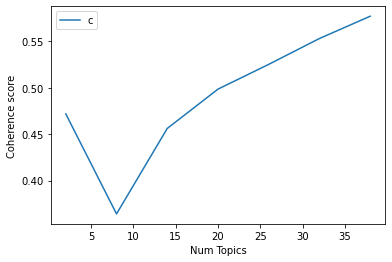

In [57]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4718
Num Topics = 8  has Coherence Value of 0.3641
Num Topics = 14  has Coherence Value of 0.4561
Num Topics = 20  has Coherence Value of 0.4985
Num Topics = 26  has Coherence Value of 0.5251
Num Topics = 32  has Coherence Value of 0.553
Num Topics = 38  has Coherence Value of 0.577


In [59]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.131*"effort" + 0.110*"subject" + 0.104*"faculty" + 0.102*"student" + '
  '0.070*"concern" + 0.067*"explain" + 0.027*"important" + 0.027*"inspire" + '
  '0.019*"nice" + 0.016*"exercise"'),
 (1,
  '0.162*"quiz" + 0.143*"hard" + 0.111*"instructor" + 0.082*"lesson" + '
  '0.082*"online" + 0.050*"great" + 0.042*"give" + 0.024*"patience" + '
  '0.021*"receive" + 0.016*"task"'),
 (2,
  '0.189*"meet" + 0.142*"assessment" + 0.136*"semester" + 0.081*"upload" + '
  '0.037*"improve" + 0.029*"week" + 0.029*"clarification" + 0.024*"prof" + '
  '0.021*"school" + 0.021*"entire"'),
 (3,
  '0.071*"material" + 0.058*"day" + 0.055*"due" + 0.053*"study" + '
  '0.050*"schedule" + 0.047*"regard" + 0.047*"assignment" + 0.047*"internet" + '
  '0.045*"time" + 0.040*"connection"'),
 (4,
  '0.196*"discussion" + 0.190*"topic" + 0.170*"discuss" + 0.062*"understand" + '
  '0.043*"helpful" + 0.020*"detail" + 0.017*"choose" + 0.014*"summative" + '
  '0.014*"check" + 0.011*"passionate"'),
 (5,
  '0.139*"teach

In [63]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['removed_stopwords']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['removed_stopwords'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            12.0              0.0828   
1            1             0.0              0.0500   
2            2             6.0              0.0724   
3            3             4.0              0.0757   
4            4             0.0              0.1634   
5            5            18.0              0.1552   
6            6             4.0              0.0724   
7            7             9.0              0.0923   
8            8             8.0              0.0652   
9            9             0.0              0.0500   

                                            Keywords  \
0  module, post, exam, final, grade, late, midter...   
1  effort, subject, faculty, student, concern, ex...   
2  class, meeting, synchronous, conduct, attend, ...   
3  discussion, topic, discuss, understand, helpfu...   
4  effort, subject, faculty, student, concern, ex...   
5  give, examination, part, understanding, facili...   
6  discussion, topic, discuss, understand, helpfu...   
7  answer, problem, query, considerate, learning,...   
8  good, safe, work, po, stay, thing, chance, sem...   
9  effort, subject, faculty, student, concern, ex...   

                                                Text  
0  [uploading, video, discussion, suggest, discus...  
1  [kind, students, classmates, even, talked, gla...  
2  [improved, hope, considers, personal, necessar...  
3  [subject, topics, easy, faculty, concerned, pa...  
4                                   [give, examples]  
5  [dedication, teaching, evident, throughout, se...  
6  [lecture, videos, informative, activities, don...  
7  [method, teaching, helps, understand, lesson, ...  
8  [passion, teaching, clearly, visible, felt, us...  
9  [appreciate, faculty, concerned, subject, effo...

In [64]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.1816   
1        1.0              0.2146   
2        2.0              0.2037   
3        3.0              0.2364   
4        4.0              0.1427   

                                            Keywords  \
0  effort, subject, faculty, student, concern, ex...   
1  quiz, hard, instructor, lesson, online, great,...   
2  meet, assessment, semester, upload, improve, w...   
3  material, day, due, study, schedule, regard, a...   
4  discussion, topic, discuss, understand, helpfu...   

                                                Text  
0  [although, told, still, disappointing, class, ...  
1  [thank, po, professor, teacher, guide, semeste...  
2                                                 []  
3  [recorded, meeting, usually, essed, google, dr...  
4                                                 []

In [65]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0.0              12.0  module, post, exam, final, grade, late, midter...   
1.0               0.0  effort, subject, faculty, student, concern, ex...   
2.0               6.0  class, meeting, synchronous, conduct, attend, ...   
3.0               4.0  discussion, topic, discuss, understand, helpfu...   
4.0               0.0  effort, subject, faculty, student, concern, ex...   
...               ...                                                ...   
848.0            11.0  activity, give, score, hour, law, item, specif...   
849.0            19.0  teacher, learn, lot, point, care, year, leave,...   
850.0             6.0  class, meeting, synchronous, conduct, attend, ...   
851.0             0.0  effort, subject, faculty, student, concern, ex...   
852.0             4.0  discussion, topic, discuss, understand, helpfu...   

       Num_Documents  Perc_Documents  
0.0            136.0          0.1594  
1.0             32.0          0.0375  
2.0             42.0          0.0492  
3.0             32.0          0.0375  
4.0             24.0          0.0281  
...              ...             ...  
848.0            NaN             NaN  
849.0            NaN             NaN  
850.0            NaN             NaN  
851.0            NaN             NaN  
852.0            NaN             NaN  

[853 rows x 4 columns]